In [1]:
import os
import torch
import datasets.paths as d_path
import torchvision

from tv_ref.engine import train_one_epoch, evaluate
from utils.init import reproducibility, clean_memory_get_device
from config import ConfigArgs
from utils.train import EarlyStopper, TrainingInfo, epoch_end_print, get_dataloaders, get_datasets
from utils.plot import plot_losses
from IPython.display import clear_output
from tv_custom.faster_rcnn import fasterrcnn_resnet50_fpn
from datasets.reflacx.lesion_detection import REFLACXLesionDetectionDataset
from engine.lesion_detection import check_best, end_train, load_backbone

import warnings
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
device = clean_memory_get_device()
# device = torch.device("cpu")
reproducibility()
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

This notebook will running on device: [CUDA]
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large 

In [3]:
from config.dataset import REFLACXLesionDetectionDatasetArgs
from config.model import FasterRCNNArgs
from config.training import LesionDetectionArgs

training_args = LesionDetectionArgs(
    name="lesion_detection",
    batch_size=4,
    early_stopping_patience = 30,
)
dataset_args = REFLACXLesionDetectionDatasetArgs(
    image_size=128,
)

cl_model_name = "MCL_resnet50_accuracy_0_1433_epoch48_10-08-2023 15-58-25"

configs = [
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=FasterRCNNArgs(
    #         name="CL_NoFix",
    #         weights="cl",
    #         cl_model_name=cl_model_name,
    #         trainable_backbone_layers=5,
    #     )
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=FasterRCNNArgs(
    #         name="CL_Fix5",
    #         weights="cl",
    #         cl_model_name=cl_model_name,
    #         trainable_backbone_layers=0,
    #     )
    # ),
    
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=FasterRCNNArgs(
    #         name="CL_Fix5Layers",
    #         weights="cl",
    #         cl_model_name=cl_model_name,
    #         trainable_backbone_layers=0,
    #     ),
    # ),

    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=FasterRCNNArgs(
    #         name="ImageNet_Fix5layers",
    #         weights="imagenet",
    #         trainable_backbone_layers=0,
    #     )
    # ),

    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=FasterRCNNArgs(
    #         name="CL_Fix2Layers",
    #         weights="cl",
    #         cl_model_name=cl_model_name,
    #         trainable_backbone_layers=3,
    #     )
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=FasterRCNNArgs(
    #         name="ImageNet_Fix2Layers",
    #         weights="imagenet",
    #         trainable_backbone_layers=3,
    #     )
    # ),
    # ConfigArgs(
    #     training=training_args,
    #     dataset=dataset_args,
    #     model=FasterRCNNArgs(
    #         name="random",
    #         weights=None,
    #         trainable_backbone_layers=5,
    #     )
    # ),
]

In [4]:
num_epochs = 200  # 200
train_infos: list[TrainingInfo] = []

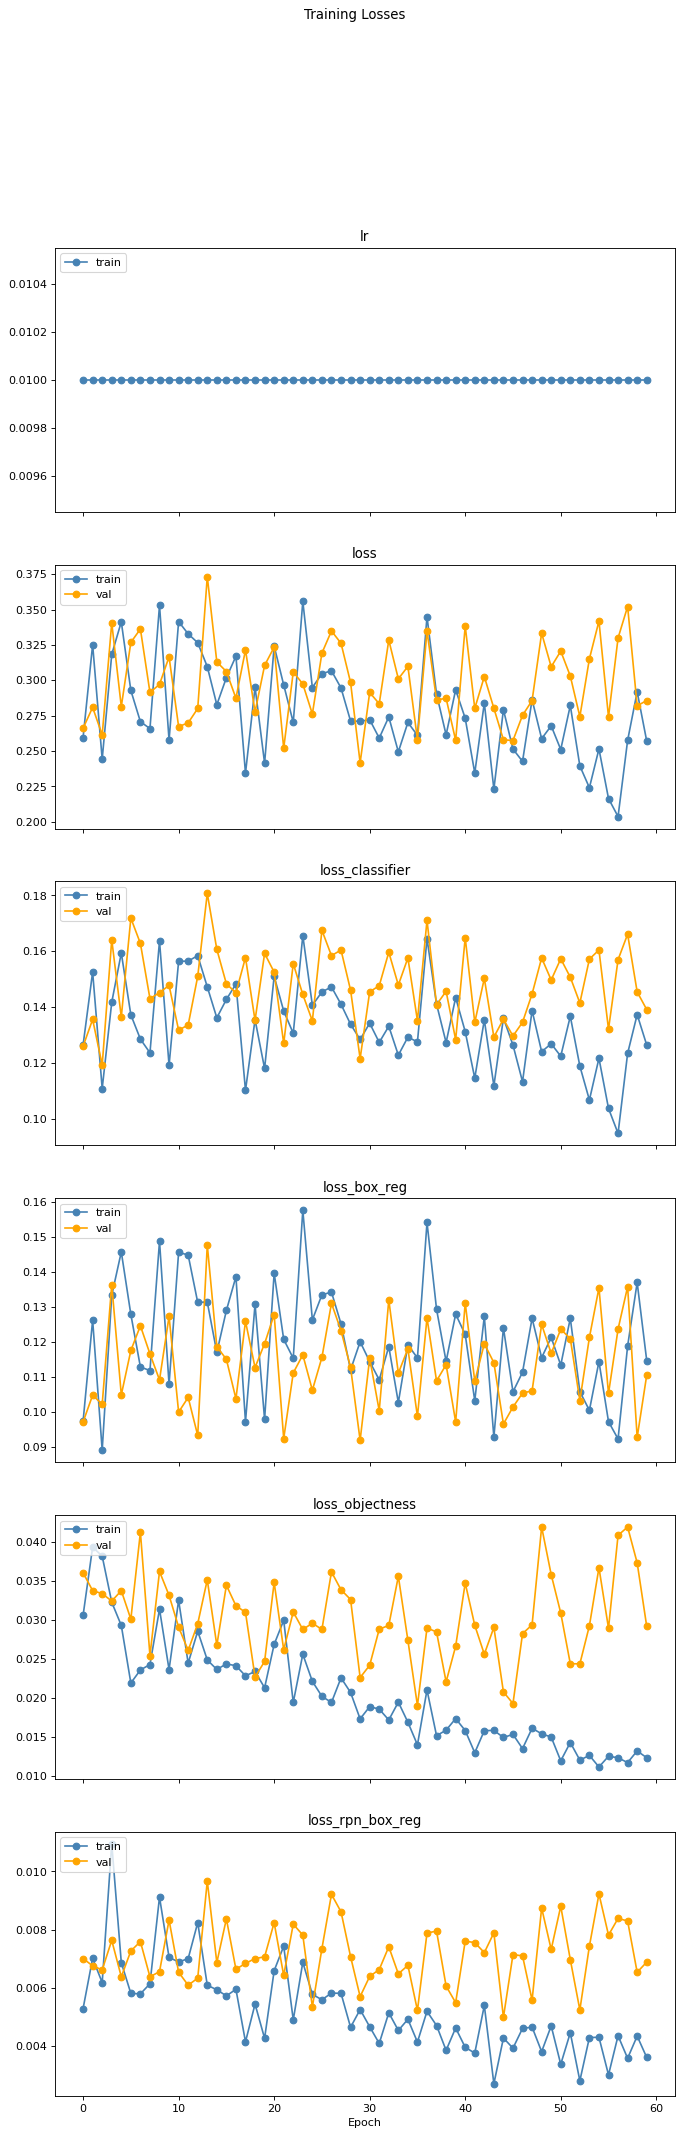

| Epoch [60] Done | It has took [326.58] min, Avg time: [326.58] sec/epoch | Estimate time for [200] epochs: [1088.60] min | Epoch took [267.850726] sec |  Patience [29] |
| Patience reached [30], EarlyStopping end |
| Training Done, start testing! | [60] Epochs Training time: [19594.859659] seconds, Avg time / Epoch: [326.5809943166667] seconds
========================================For Training [lesion_detection - CL_Fix5Layers]========================================
LesionDetectionArgs(name='lesion_detection', learning_rate=0.01, sgd_momentum=0.9, batch_size=4, weight_decay=1e-05, early_stopping_patience=30, warmup_epoch=0)
REFLACXLesionDetectionDatasetArgs(image_size=128, label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'])
FasterRCNNArgs(name='CL_Fix5Layers', weights='cl', cl_model_name='MCL_resnet50_accuracy_0_1433_epoch48_10-08-2023 15-58-25', trainable_backbone_layers=0, release_fixed_weights_after=None)

Best m

In [5]:
from utils.train import set_weights_trainable

for config in configs:
    device = clean_memory_get_device()
    reproducibility()

    train_info = TrainingInfo(config)

    model = fasterrcnn_resnet50_fpn(
        weights=None,
        # weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1
        # weights_backbone=weights_backbone,
        # trainable_backbone_layers=trainable_backbone_layers,
    )

    # weights.
    backbone = load_backbone(config, device)
    model.backbone = backbone
    model.to(device)

    dataset_args = {
        "df_path": os.path.join('spreadsheets', "reflacx.csv"),
        "mimic_eye_path": d_path.MIMIC_EYE_PATH,
        "image_size": config.dataset.image_size,
        "label_cols": config.dataset.label_cols,
    }

    train_dataset, val_dataset, _ = get_datasets(
        dataset_args=dataset_args,
        dataset_class=REFLACXLesionDetectionDataset,
    )

    train_dataloader, val_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        batch_size=config.training.batch_size,
        drop_last=False,
    )

    optimiser = torch.optim.SGD(
        params=[p for p in model.parameters() if p.requires_grad],
        lr=config.training.learning_rate,
        momentum=config.training.sgd_momentum,
        weight_decay=config.training.weight_decay,
    )

    early_stopper = None
    if config.training.early_stopping_patience:
        early_stopper = EarlyStopper(
            patience=config.training.early_stopping_patience)

    train_info.timer.start_training()

    for e in range(1, num_epochs + 1):
        train_info.epoch = e
        train_info.timer.start_epoch()
        for t_i in train_infos:
            print(t_i)
        print(train_info)

        if (not config.model.release_fixed_weights_after is None) and (e > config.model.release_fixed_weights_after):
            model, optimiser = set_weights_trainable(model, optimiser, "backbone")

        train_logger = train_one_epoch(
            model=model,
            optimiser=optimiser,
            data_loader=train_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
        )

        train_info.train_losses.append(train_logger.get_data())
        model.eval()

        val_logger, val_evaluator = evaluate(
            model=model,
            data_loader=val_dataloader,
            device=device,
            return_evaluator=True,
        )

        train_info.val_losses.append(val_logger.get_data())
        clear_output()
        plot_losses(
            train_info.train_losses,
            train_info.val_losses,
        )
        epoch_end_print(train_info, early_stopper, num_epochs)

        if early_stopper and train_info.epoch > config.training.warmup_epoch:
            train_info = check_best(
                train_info=train_info,
                model=model,
                optimiser=optimiser,
                val_evaluator=val_evaluator,
            )
            to_stop = early_stopper.early_stop(
                train_info.val_losses[-1]['loss'])
            if to_stop:
                print(
                    f"| Patience reached [{early_stopper.counter}], EarlyStopping end |")
                break

    train_info = end_train(
        train_info=train_info,
        model=model,
        optimiser=optimiser,
        val_evaluator=val_evaluator,
    )

    train_infos.append(train_info)

========================================For Training [lesion_detection - CL_Fix5Layers]========================================
LesionDetectionArgs(name='lesion_detection', learning_rate=0.01, sgd_momentum=0.9, batch_size=4, weight_decay=1e-05, early_stopping_patience=30, warmup_epoch=0)
REFLACXLesionDetectionDatasetArgs(image_size=128, label_cols=['Pulmonary edema', 'Enlarged cardiac silhouette', 'Consolidation', 'Atelectasis', 'Pleural abnormality'])
FasterRCNNArgs(name='CL_Fix5Layers', weights='cl', cl_model_name='MCL_resnet50_accuracy_0_1433_epoch48_10-08-2023 15-58-25', trainable_backbone_layers=0, release_fixed_weights_after=None)

Best model has been saved to: [lesion_detection_CL_Fix5Layers_ap_0_0894_ar_0_5767_epoch30_10-15-2023 17-25-45]
The final model has been saved to: [lesion_detection_CL_Fix5Layers_ap_0_0944_ar_0_6035_epoch60_10-15-2023 20-23-36]



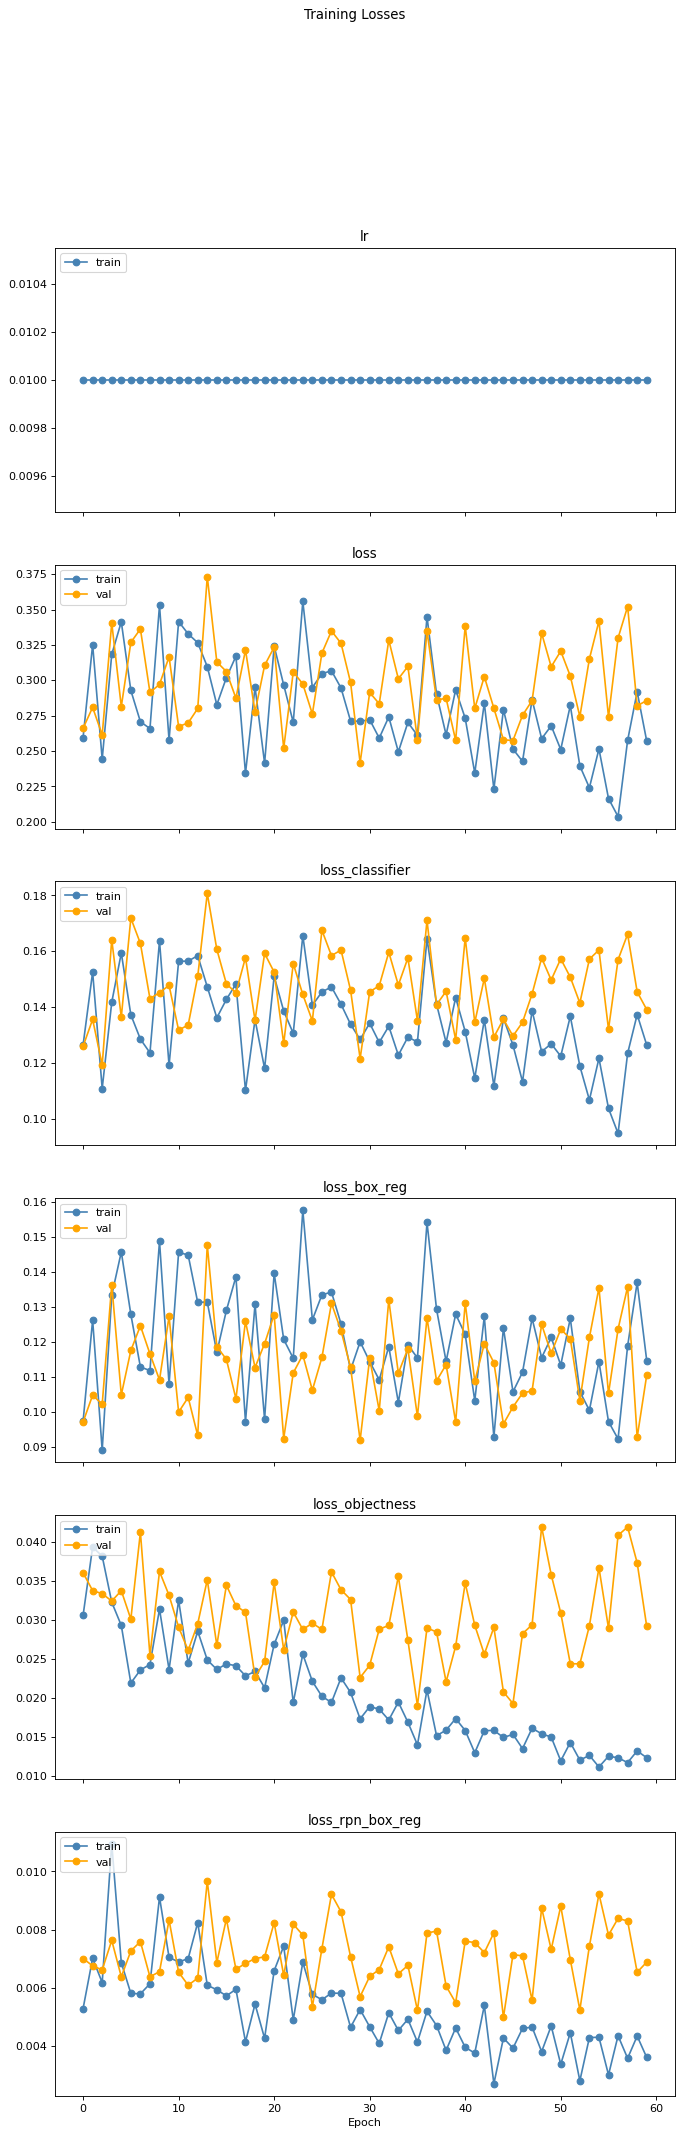

In [6]:
for t in train_infos :
    print(t)
    plot_losses(
        t.train_losses,
        t.val_losses,
    )

In [17]:
# Evaluate all train_infos on the best
from utils.checkpoint import load_checkpoints
from engine.lesion_detection import get_ap_ar

performances = {}

for t in train_infos:

    train_info, cp = load_checkpoints(t.best_val_loss_model_path, device)
    config = train_info.config
    model = fasterrcnn_resnet50_fpn(
        weights=None,
    )
    model.backbone = load_backbone(config, device)
    model.to(device)
    model.load_state_dict(cp["model"])
    model.eval()

    dataset_args = {
        "df_path": os.path.join('spreadsheets', "reflacx.csv"),
        "mimic_eye_path": d_path.MIMIC_EYE_PATH,
        "image_size": config.dataset.image_size,
        "label_cols": config.dataset.label_cols,
    }

    _, _, test_dataset = get_datasets(
        dataset_args=dataset_args,
        dataset_class=REFLACXLesionDetectionDataset, 
    )

    _, _, test_dataloader = get_dataloaders(
        train_dataset,
        val_dataset,
        test_dataset,
        batch_size=config.training.batch_size,
        drop_last=False,
    )

    _, test_evaluator = evaluate(
        model=model,
        data_loader=test_dataloader,
        device=device,
        return_evaluator=True,
    )

    performance_dict = get_ap_ar(
        test_evaluator.coco_eval["bbox"],
    )

    print(t)
    print(performance_dict)

    performances[f"{config.training.name} - {config.model.name}"] = performance_dict

    with open(os.path.join('checkpoints', t.best_val_loss_model_path, 'performance.txt'), 'w') as f:
        f.write(str(t) + "\n" + "Best: \n" + str(performance_dict))

creating index...
index created!
Test:  [  0/114]  eta: 0:00:59  model_time: 0.3383 (0.3383)  evaluator_time: 0.0050 (0.0050)  loss: 0.3418 (0.3418)  loss_classifier: 0.1629 (0.1629)  loss_box_reg: 0.1552 (0.1552)  loss_objectness: 0.0140 (0.0140)  loss_rpn_box_reg: 0.0097 (0.0097)  time: 0.5243  data: 0.1790  max mem: 1374
Test:  [100/114]  eta: 0:00:05  model_time: 0.1700 (0.1735)  evaluator_time: 0.0050 (0.0054)  loss: 0.2821 (0.2753)  loss_classifier: 0.1423 (0.1349)  loss_box_reg: 0.0962 (0.1069)  loss_objectness: 0.0170 (0.0263)  loss_rpn_box_reg: 0.0057 (0.0072)  time: 0.3610  data: 0.1837  max mem: 1374
Test:  [113/114]  eta: 0:00:00  model_time: 0.1670 (0.1725)  evaluator_time: 0.0050 (0.0054)  loss: 0.2648 (0.2766)  loss_classifier: 0.1321 (0.1351)  loss_box_reg: 0.0921 (0.1072)  loss_objectness: 0.0261 (0.0270)  loss_rpn_box_reg: 0.0083 (0.0073)  time: 0.3640  data: 0.1896  max mem: 1374
Test: Total time: 0:00:41 (0.3644 s / it)
Averaged stats: model_time: 0.1670 (0.1725)  e

In [18]:
p_df = pd.DataFrame(performances).transpose()

In [19]:
p_df

,ap,ar
lesion_detection - CL_Fix5Layers,0.081506,0.640947


In [ ]:
param_dict = {}
for n, p in model.named_parameters():
    param_dict.update({n: {"#params":p.nelement()}})

In [ ]:
pd.DataFrame(param_dict).transpose().sort_values("#params", ascending=False).head(20)

,#params
backbone.body.layer4.1.conv2.weight,2359296
backbone.body.layer4.0.conv2.weight,2359296
backbone.body.layer4.1.conv1.weight,2359296
backbone.body.layer4.0.conv1.weight,1179648
backbone.body.layer3.0.conv2.weight,589824
rpn.head.conv.0.0.weight,589824
backbone.fpn.layer_blocks.3.0.weight,589824
backbone.fpn.layer_blocks.2.0.weight,589824
backbone.fpn.layer_blocks.1.0.weight,589824
backbone.body.layer3.1.conv1.weight,589824
